> *By Hammad Zahid | Data Scientist & Analyst*  
> 🔗 [LinkedIn](https://www.linkedin.com/in/hammad-zahid-xyz) | 🐙 [GitHub](https://github.com/Hamad-Ansari) | ✉️ [Email](Hammadzahid24@gmail.com)

(np.float64(-0.5), np.float64(1535.5), np.float64(1023.5), np.float64(-0.5))

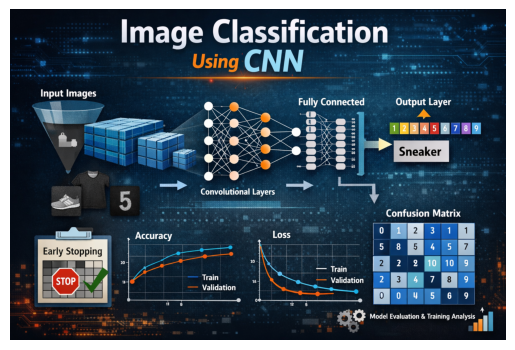

In [1]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("mage.png")   # path to your image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")


In [ ]:
# Image Classification
# Fashion-MNIST dataset image classification using NN architecture

# ============================================
# 1. Import Libraries
# ============================================
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# ============================================
# 2. Load and Explore Data
# ============================================
# Load Fashion-MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Dataset information
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Number of Classes: {len(class_names)}")
print(f"Class Names: {class_names}")
print(f"Pixel Value Range: [{train_images.min()}, {train_images.max()}]")

DATASET INFORMATION
Train Images Shape: (60000, 28, 28)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)
Number of Classes: 10
Class Names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Pixel Value Range: [0, 255]



Visualizing sample images...


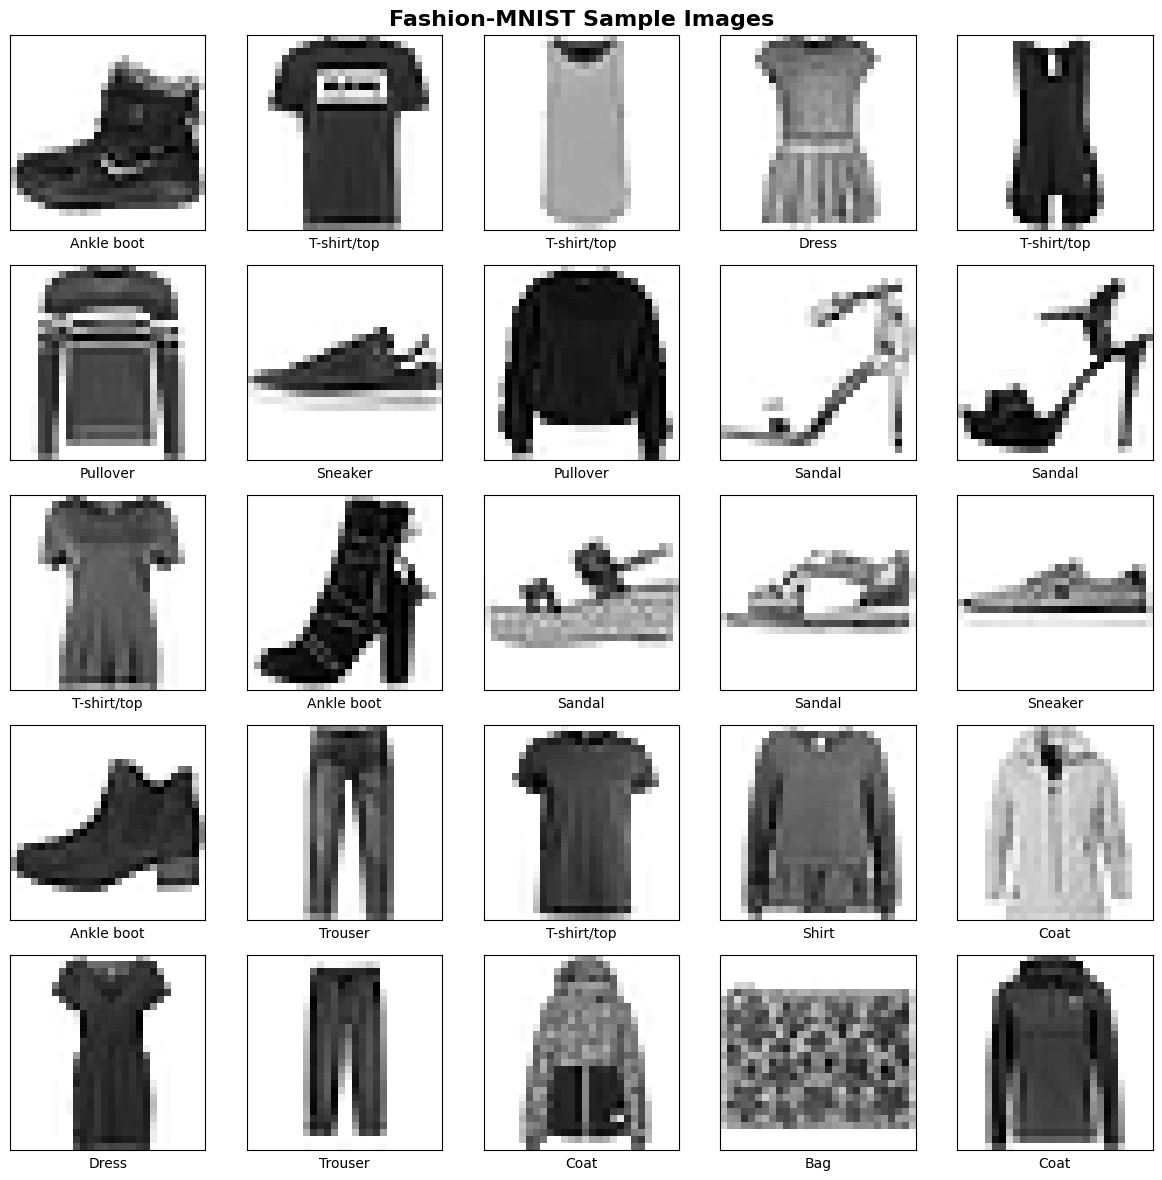


Analyzing class distribution...


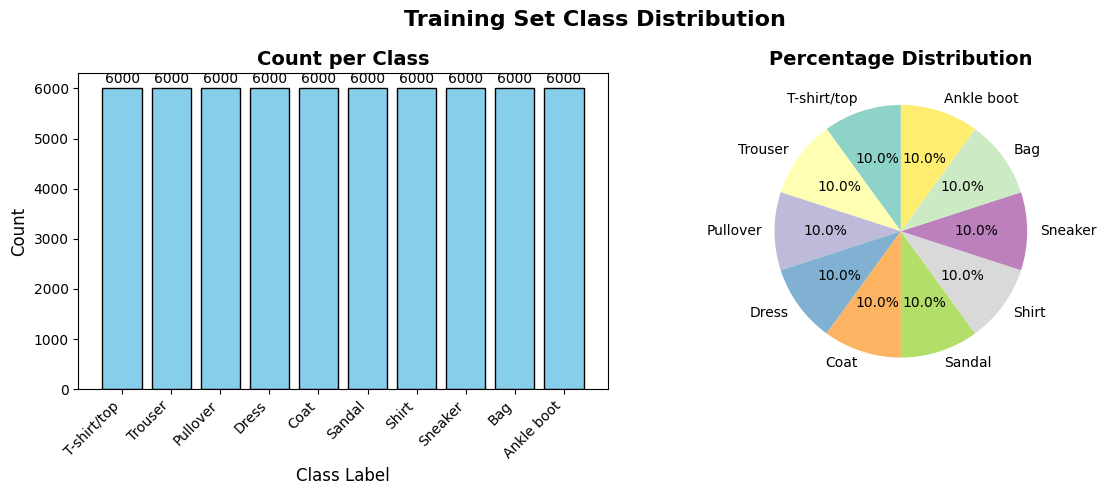

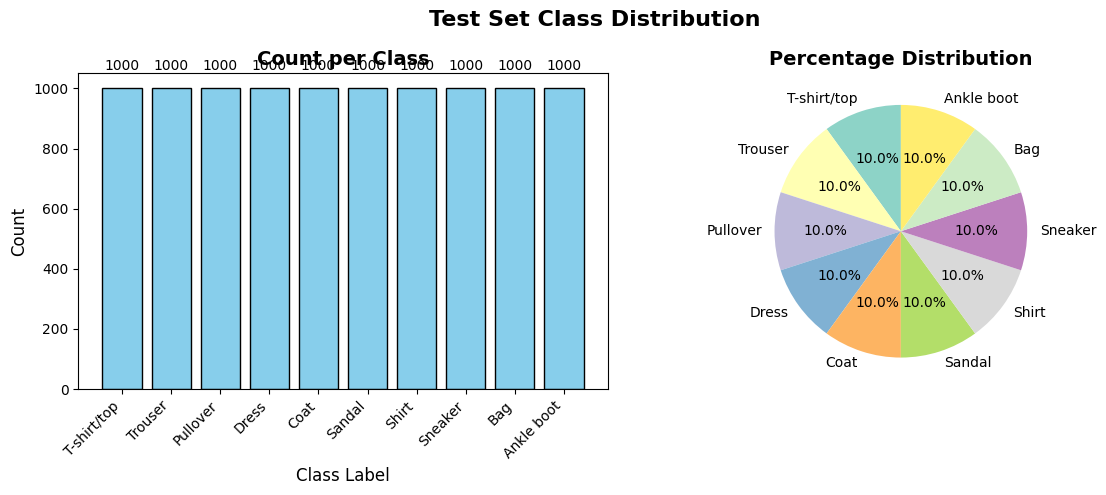

In [5]:
# ============================================
# 3. Data Visualization
# ============================================
def visualize_dataset(images, labels, class_names, num_samples=25):
    """
    Visualize sample images from the dataset
    """
    plt.figure(figsize=(12, 12))
    for i in range(min(num_samples, len(images))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(class_names[labels[i]], fontsize=10)
        plt.grid(False)
    plt.suptitle('Fashion-MNIST Sample Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
# Display sample images
print("\nVisualizing sample images...")
visualize_dataset(train_images, train_labels, class_names)

# Class distribution visualization
def plot_class_distribution(labels, class_names, title="Class Distribution"):
    """
    Plot the distribution of classes in the dataset
    """
    plt.figure(figsize=(12, 5))
    
    # Count plot
    plt.subplot(1, 2, 1)
    unique, counts = np.unique(labels, return_counts=True)
    bars = plt.bar(unique, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Class Label', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Count per Class', fontsize=14, fontweight='bold')
    plt.xticks(unique, [class_names[i] for i in unique], rotation=45, ha='right')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                str(count), ha='center', va='bottom', fontsize=10)
    
    # Pie chart
    plt.subplot(1, 2, 2)
    plt.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90,
            colors=plt.cm.Set3(np.linspace(0, 1, len(class_names))))
    plt.title('Percentage Distribution', fontsize=14, fontweight='bold')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\nAnalyzing class distribution...")
plot_class_distribution(train_labels, class_names, "Training Set Class Distribution")
plot_class_distribution(test_labels, class_names, "Test Set Class Distribution")

In [6]:

# ============================================
# 4. Data Preprocessing
# ============================================
def preprocess_data(train_images, test_images):
    """
    Preprocess images: normalize and reshape
    """
    # Normalize pixel values to [0, 1]
    train_images = train_images.astype('float32') / 255.0
    test_images = test_images.astype('float32') / 255.0
    
    # Add channel dimension (for CNN)
    train_images = train_images.reshape(-1, 28, 28, 1)
    test_images = test_images.reshape(-1, 28, 28, 1)
    
    return train_images, test_images

# Preprocess data
print("\nPreprocessing data...")
train_images, test_images = preprocess_data(train_images, test_images)
print(f"Shape after preprocessing - Train: {train_images.shape}, Test: {test_images.shape}")

# One-hot encode labels
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, 10)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, 10)


Preprocessing data...
Shape after preprocessing - Train: (60000, 28, 28, 1), Test: (10000, 28, 28, 1)


In [7]:
# ============================================
# 5. Build Neural Network Models
# ============================================
def build_simple_nn():
    """
    Build a simple neural network model
    """
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28, 1)),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
    return model

def build_cnn():
    """
    Build a Convolutional Neural Network model
    """
    model = models.Sequential([
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                     input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [8]:
# ============================================
# 6. Model Training Configuration
# ============================================
def create_callbacks(model_name):
    """
    Create training callbacks
    """
    # Create directory for saving models
    os.makedirs('models', exist_ok=True)
    
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        
        # Save best model
        ModelCheckpoint(
            filepath=f'models/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        
        # Save model periodically
        ModelCheckpoint(
            filepath=f'models/{model_name}_epoch_{{epoch:02d}}.h5',
            save_freq='epoch',
            period=10
        )
    ]
    
    return callbacks

In [15]:
# ============================================
# 6. Model Training Configuration
# ============================================
def create_callbacks(model_name):
    """
    Create training callbacks
    """
    # Create directory for saving models
    os.makedirs('models', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when validation loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        
        # Save best model
        ModelCheckpoint(
            filepath=f'models/{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir=f'logs/{model_name}',
            histogram_freq=1,
            write_graph=True,
            write_images=True
        )
    ]
    
    return callbacks

# ============================================
# 7. Train Models
# ============================================
def train_model(model, model_name, train_images, train_labels, 
                test_images, test_labels, epochs=50, batch_size=64):
    """
    Train the model with given parameters
    """
    print(f"\n{'='*50}")
    print(f"TRAINING {model_name}")
    print(f"{'='*50}")
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Display model architecture
    print("\nModel Summary:")
    model.summary()
    
    # Create callbacks
    callbacks = create_callbacks(model_name)
    
    # Calculate steps per epoch
    steps_per_epoch = len(train_images) // batch_size
    validation_steps = len(test_images) // batch_size
    
    print(f"\nTraining Parameters:")
    print(f"Epochs: {epochs}")
    print(f"Batch Size: {batch_size}")
    print(f"Steps per Epoch: {steps_per_epoch}")
    print(f"Training Samples: {len(train_images)}")
    print(f"Validation Samples: {len(test_images)}")
    
    # Train model
    print("\nStarting training...")
    start_time = datetime.now()
    
    history = model.fit(
        train_images, train_labels,
        validation_data=(test_images, test_labels),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
    
    end_time = datetime.now()
    training_time = end_time - start_time
    
    print(f"\nTraining completed in {training_time}")
    
    return model, history

# Train both models
print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

# Train Simple NN
print("\nTraining Simple Neural Network...")
simple_nn = build_simple_nn()
simple_nn, history_simple = train_model(
    simple_nn, "simple_nn",
    train_images, train_labels_onehot,
    test_images, test_labels_onehot,
    epochs=5, batch_size=64
)

print("\n" + "="*50)
print("\nTraining CNN Model...")
# Train CNN
cnn_model = build_cnn()
cnn_model, history_cnn = train_model(
    cnn_model, "cnn_model",
    train_images, train_labels_onehot,
    test_images, test_labels_onehot,
    epochs=5, batch_size=64
)


MODEL TRAINING

Training Simple Neural Network...

TRAINING simple_nn

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)


Training Parameters:
Epochs: 5
Batch Size: 64
Steps per Epoch: 937
Training Samples: 60000
Validation Samples: 10000

Starting training...
Epoch 1/5
922/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6807 - loss: 1.3199
Epoch 1: val_accuracy improved from None to 0.83670, saving model to models/simple_nn_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7627 - loss: 1.0103 - val_accuracy: 0.8367 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 2/5
925/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8221 - loss: 0.7240
Epoch 2: val_accuracy improved from 0.83670 to 0.83870, saving model to models/simple_nn_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8256 - loss: 0.6941 - val_accuracy: 0.8387 - val_loss: 0.6206 - learning_rate: 0.0010
Epoch 3/5
918/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8333 - loss: 0.6348
Epoch 3: val_accuracy improved from 0.83870 to 0.84230, saving model to models/simple_nn_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8350 - loss: 0.6233 - val_accuracy: 0.8423 - val_loss: 0.5778 - learning_rate: 0.0010
Epoch 4/5
915/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8377 - loss: 0.5987
Epoch 4: val_accuracy improved from 0.84230 to 0.84420, saving model to models/simple_nn_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8376 - loss: 0.5919 - val_accuracy: 0.8442 - val_loss: 0.5652 - learning_rate: 0.0010
Epoch 5/5
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.5880
Epoch 5: val_accuracy improved from 0.84420 to 0.84730, saving model to models/simple_nn_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8378 - loss: 0.5842 - val_accuracy: 0.8473 - val_loss: 0.5444 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.

Training completed in 0:00:14.478640


Training CNN Model...

TRAINING cnn_model

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 619,114 (2.36 MB)

 Trainable params: 617,450 (2.36 MB)

 Non-trainable params: 1,664 (6.50 KB)


Training Parameters:
Epochs: 5
Batch Size: 64
Steps per Epoch: 937
Training Samples: 60000
Validation Samples: 10000

Starting training...
Epoch 1/5
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6731 - loss: 1.5506
Epoch 1: val_accuracy improved from None to 0.86460, saving model to models/cnn_model_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.7756 - loss: 1.1450 - val_accuracy: 0.8646 - val_loss: 0.7275 - learning_rate: 0.0010
Epoch 2/5
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8632 - loss: 0.6883
Epoch 2: val_accuracy improved from 0.86460 to 0.88780, saving model to models/cnn_model_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.8720 - loss: 0.6198 - val_accuracy: 0.8878 - val_loss: 0.4918 - learning_rate: 0.0010
Epoch 3/5
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8860 - loss: 0.4846
Epoch 3: val_accuracy improved from 0.88780 to 0.89490, saving model to models/cnn_model_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 67ms/step - accuracy: 0.8897 - loss: 0.4591 - val_accuracy: 0.8949 - val_loss: 0.4180 - learning_rate: 0.0010
Epoch 4/5
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8947 - loss: 0.4150
Epoch 4: val_accuracy did not improve from 0.89490
938/938 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.8979 - loss: 0.4021 - val_accuracy: 0.8944 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 5/5
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9024 - loss: 0.3892
Epoch 5: val_accuracy improved from 0.89490 to 0.91450, saving model to models/cnn_model_best.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.9046 - loss: 0.3847 - val_accuracy: 0.9145 - val_loss: 0.3460 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.

Training completed in 0:05:16.064956



MODEL EVALUATION


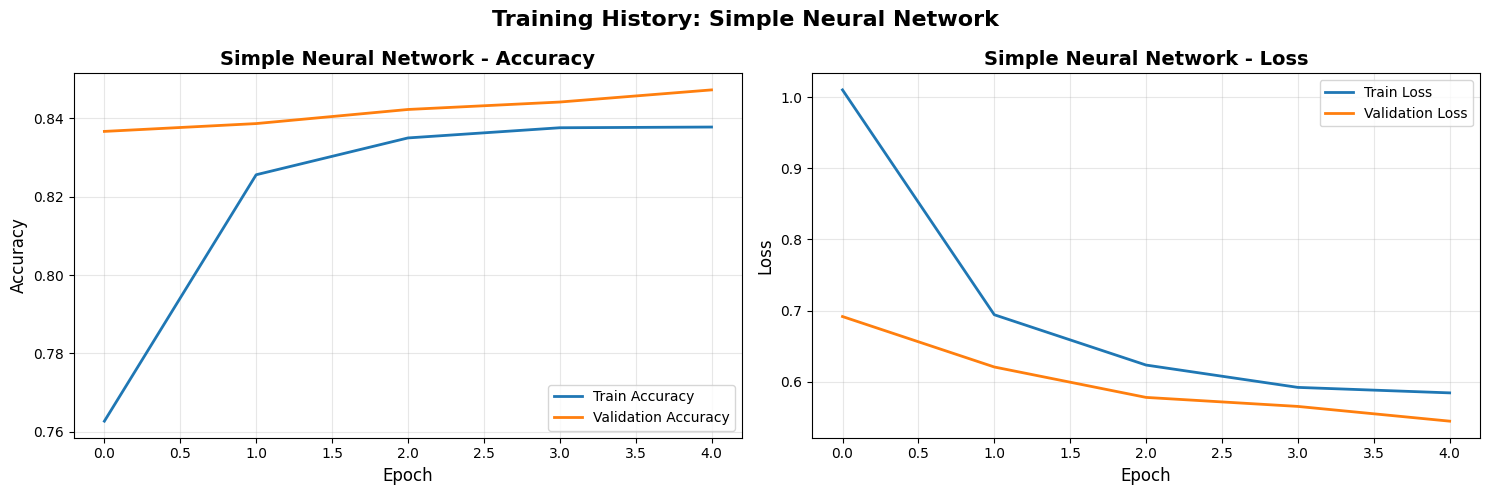

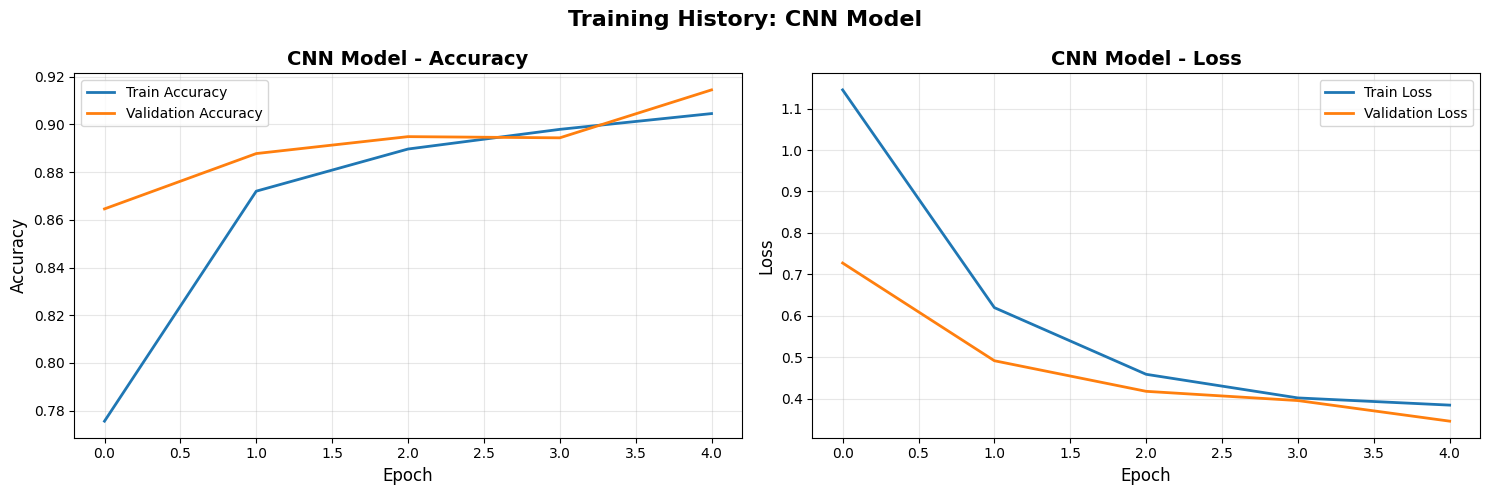


EVALUATING Simple Neural Network
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step

Test Loss: 0.5444
Test Accuracy: 0.8473
Test Error Rate: 0.1527

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.8947    0.6800    0.7727      1000
     Trouser     0.9826    0.9590    0.9706      1000
    Pullover     0.7799    0.7230    0.7504      1000
       Dress     0.7837    0.9020    0.8387      1000
        Coat     0.6899    0.8430    0.7588      1000
      Sandal     0.9279    0.9530    0.9403      1000
       Shirt     0.6379    0.5920    0.6141      1000
     Sneaker     0.9367    0.9030    0.9196      1000
         Bag     0.9408    0.9700    0.9552      1000
  Ankle boot     0.9349    0.9480    0.9414      1000

    accuracy                         0.8473     10000
   macro avg     0.8509    0.8473    0.8462     10000
weighted avg     0.8509    0.8473    0.8462     10000



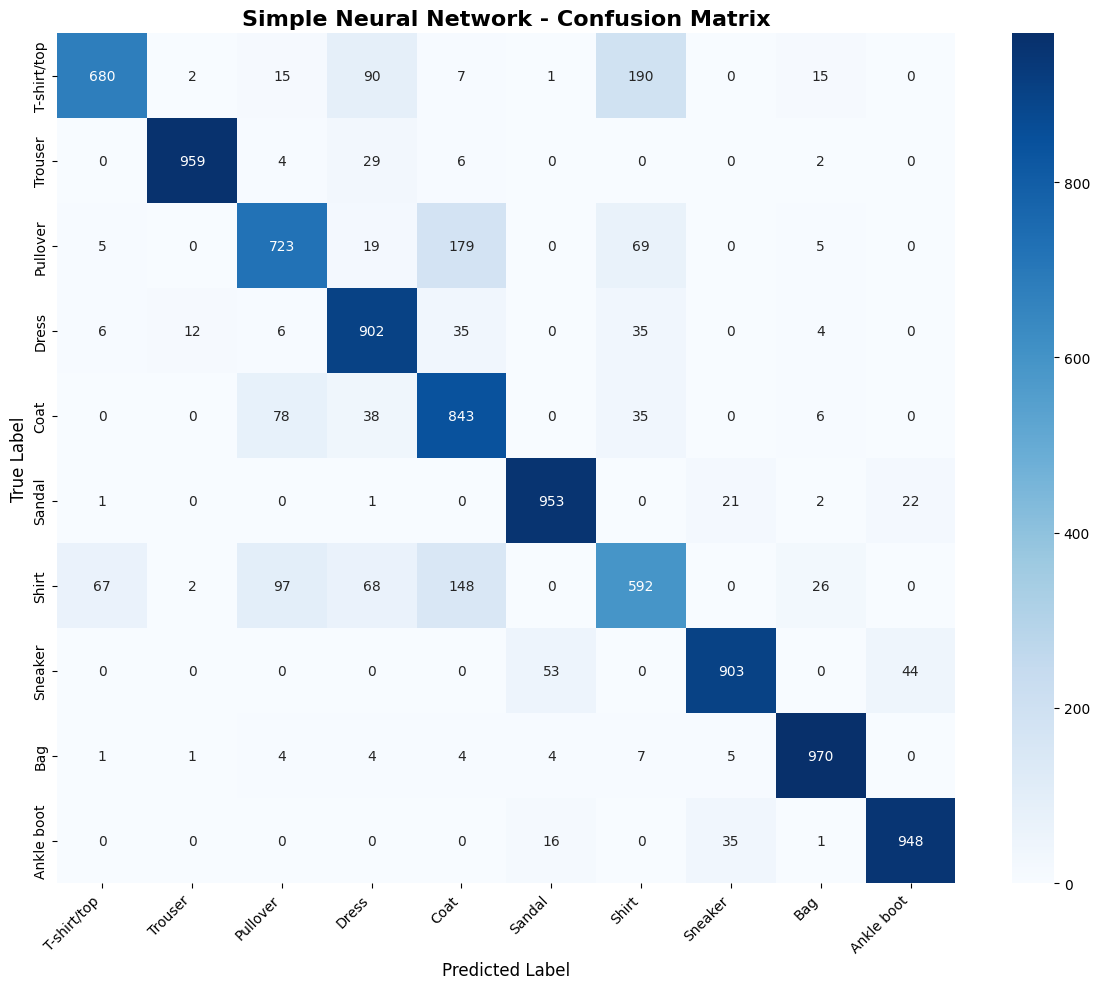


EVALUATING CNN Model
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Test Loss: 0.3460
Test Accuracy: 0.9145
Test Error Rate: 0.0855

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top     0.8629    0.8750    0.8689      1000
     Trouser     0.9909    0.9810    0.9859      1000
    Pullover     0.8217    0.9220    0.8690      1000
       Dress     0.9213    0.9020    0.9116      1000
        Coat     0.8834    0.8330    0.8574      1000
      Sandal     0.9716    0.9920    0.9817      1000
       Shirt     0.7684    0.7200    0.7434      1000
     Sneaker     0.9717    0.9610    0.9663      1000
         Bag     0.9783    0.9900    0.9841      1000
  Ankle boot     0.9758    0.9690    0.9724      1000

    accuracy                         0.9145     10000
   macro avg     0.9146    0.9145    0.9141     10000
weighted avg     0.9146    0.9145    0.9141     10000



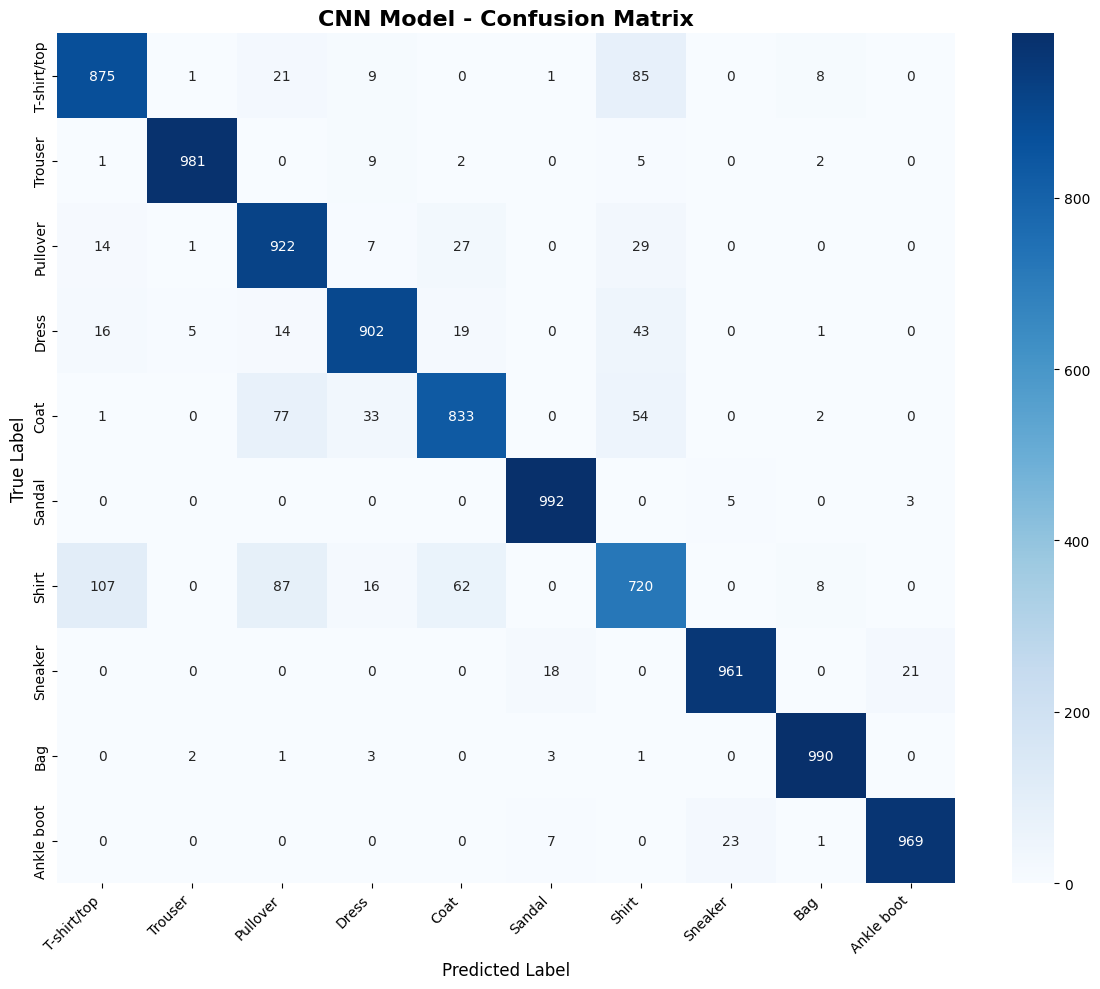

In [16]:
# ============================================
# 8. Model Evaluation and Visualization
# ============================================
def plot_training_history(history, model_name):
    """
    Plot training history (accuracy and loss)
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Training History: {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_images, test_labels, test_labels_onehot, class_names, model_name):
    """
    Evaluate model performance
    """
    print(f"\n{'='*50}")
    print(f"EVALUATING {model_name}")
    print(f"{'='*50}")
    
    # Get predictions
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(test_images, test_labels_onehot, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Error Rate: {(1-test_accuracy):.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, predicted_labels, 
                              target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return test_accuracy, predicted_labels

# Evaluate models
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Plot training history
plot_training_history(history_simple, "Simple Neural Network")
plot_training_history(history_cnn, "CNN Model")

# Evaluate Simple NN
acc_simple, pred_simple = evaluate_model(
    simple_nn, test_images, test_labels, 
    test_labels_onehot, class_names, "Simple Neural Network"
)

# Evaluate CNN
acc_cnn, pred_cnn = evaluate_model(
    cnn_model, test_images, test_labels,
    test_labels_onehot, class_names, "CNN Model"
)



MODEL COMPARISON
Simple Neural Network Accuracy: 0.8473
CNN Model Accuracy: 0.9145
Improvement: 0.0672


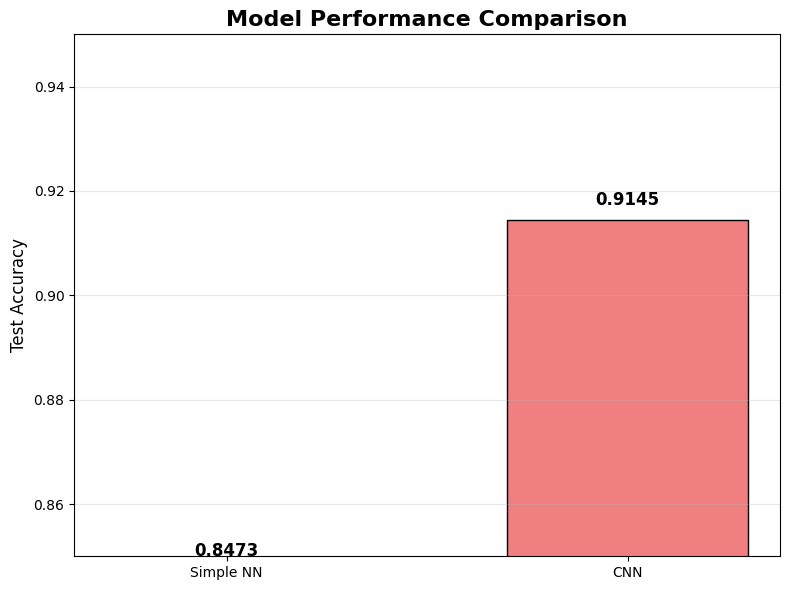

In [17]:
# ============================================
# 9. Model Comparison and Analysis
# ============================================
def plot_model_comparison(acc_simple, acc_cnn):
    """
    Compare model performances
    """
    models = ['Simple NN', 'CNN']
    accuracies = [acc_simple, acc_cnn]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral'], 
                   edgecolor='black', width=0.6)
    
    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.ylim([0.85, 0.95])
    
    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Simple Neural Network Accuracy: {acc_simple:.4f}")
print(f"CNN Model Accuracy: {acc_cnn:.4f}")
print(f"Improvement: {(acc_cnn - acc_simple):.4f}")

plot_model_comparison(acc_simple, acc_cnn)


VISUALIZING CNN PREDICTIONS


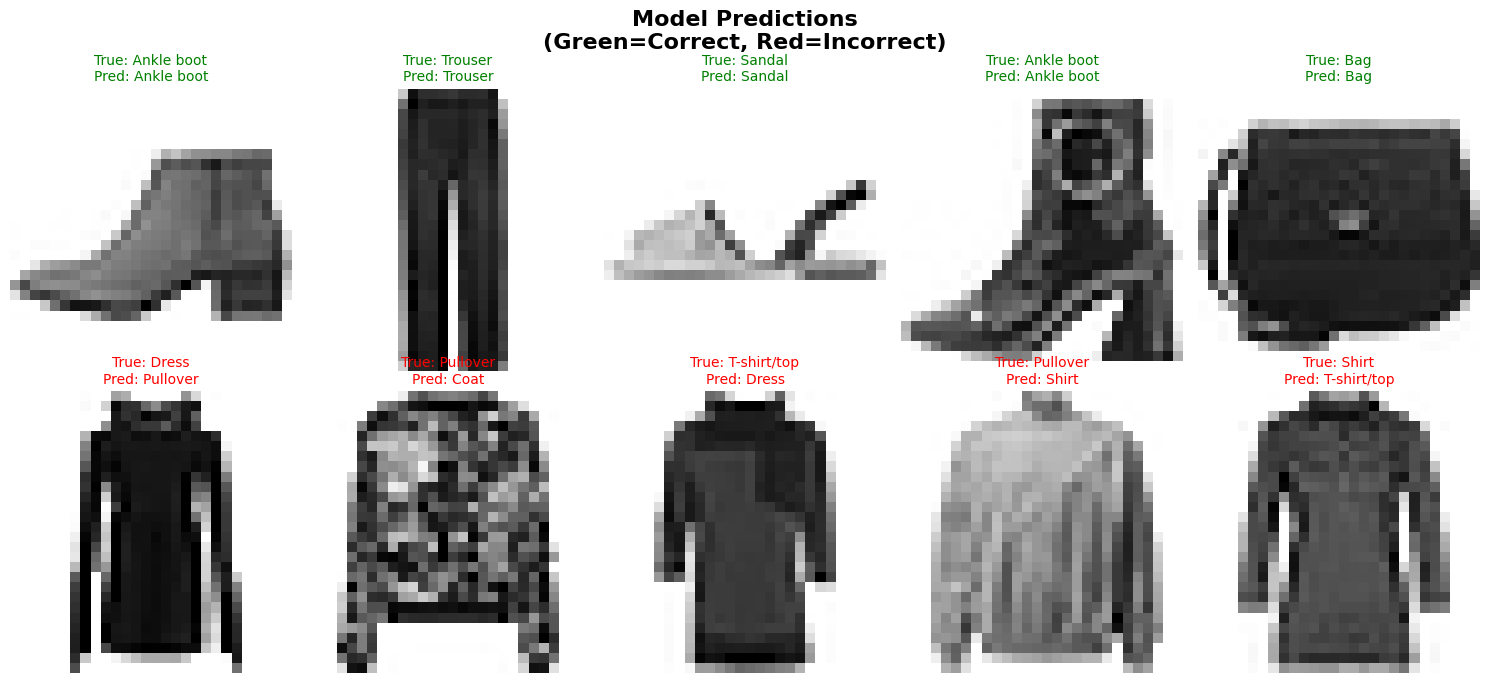


Correct predictions shown: 5
Incorrect predictions shown: 5
Total test samples: 10000
Number correct: 9145
Number incorrect: 855
Accuracy on displayed subset: 0.9145


In [18]:

# ============================================
# 10. Visualize Predictions
# ============================================
def visualize_predictions(model, images, true_labels, predicted_labels, 
                         class_names, num_samples=20):
    """
    Visualize model predictions with true labels
    """
    # Get indices of correct and incorrect predictions
    correct_indices = np.where(predicted_labels == true_labels)[0]
    incorrect_indices = np.where(predicted_labels != true_labels)[0]
    
    # Sample some predictions
    np.random.shuffle(correct_indices)
    np.random.shuffle(incorrect_indices)
    
    # Create visualization
    fig, axes = plt.subplots(2, 5, figsize=(15, 7))
    axes = axes.ravel()
    
    # Plot correct predictions
    for i in range(5):
        if i < len(correct_indices):
            idx = correct_indices[i]
            axes[i].imshow(images[idx].reshape(28, 28), cmap=plt.cm.binary)
            axes[i].set_title(f'True: {class_names[true_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}', 
                            fontsize=10, color='green')
            axes[i].axis('off')
        else:
            axes[i].axis('off')
    
    # Plot incorrect predictions
    for i in range(5, 10):
        if (i-5) < len(incorrect_indices):
            idx = incorrect_indices[i-5]
            axes[i].imshow(images[idx].reshape(28, 28), cmap=plt.cm.binary)
            axes[i].set_title(f'True: {class_names[true_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}', 
                            fontsize=10, color='red')
            axes[i].axis('off')
        else:
            axes[i].axis('off')
    
    plt.suptitle('Model Predictions\n(Green=Correct, Red=Incorrect)', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nCorrect predictions shown: {min(5, len(correct_indices))}")
    print(f"Incorrect predictions shown: {min(5, len(incorrect_indices))}")
    print(f"Total test samples: {len(true_labels)}")
    print(f"Number correct: {len(correct_indices)}")
    print(f"Number incorrect: {len(incorrect_indices)}")
    print(f"Accuracy on displayed subset: {len(correct_indices)/len(true_labels):.4f}")

print("\n" + "="*50)
print("VISUALIZING CNN PREDICTIONS")
print("="*50)
# Visualize CNN predictions
visualize_predictions(cnn_model, test_images, test_labels, pred_cnn, class_names)



Visualizing CNN feature maps...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


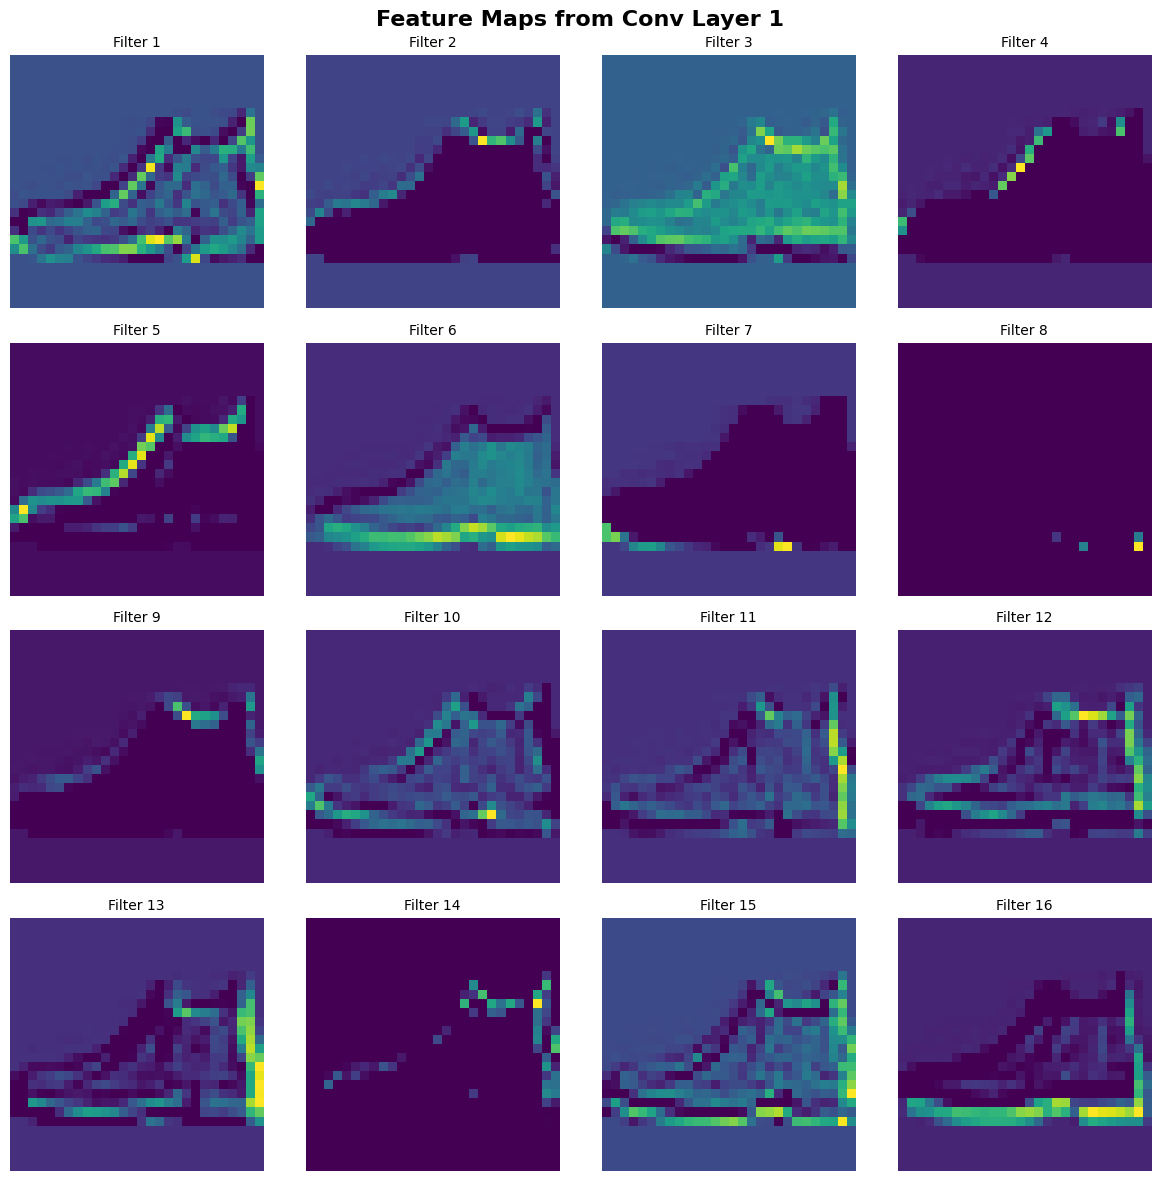

In [19]:
# ============================================
# 11. Feature Visualization (CNN only)
# ============================================
def visualize_cnn_features(model, test_images, layer_index=0, num_filters=16):
    """
    Visualize convolutional filters and feature maps
    """
    # Get the convolutional layer
    conv_layer = model.layers[layer_index]
    
    # Create a model that outputs the feature maps
    feature_map_model = models.Model(inputs=model.inputs, 
                                    outputs=conv_layer.output)
    
    # Get feature maps for a sample image
    sample_image = test_images[0:1]
    feature_maps = feature_map_model.predict(sample_image)
    
    # Visualize feature maps
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()
    
    for i in range(min(num_filters, feature_maps.shape[-1])):
        axes[i].imshow(feature_maps[0, :, :, i], cmap='viridis')
        axes[i].set_title(f'Filter {i+1}', fontsize=10)
        axes[i].axis('off')
    
    for i in range(feature_maps.shape[-1], len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Feature Maps from Conv Layer {layer_index+1}', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize first convolutional layer features
print("\nVisualizing CNN feature maps...")
try:
    visualize_cnn_features(cnn_model, test_images, layer_index=0, num_filters=16)
except Exception as e:
    print(f"Could not visualize feature maps: {e}")


ERROR ANALYSIS


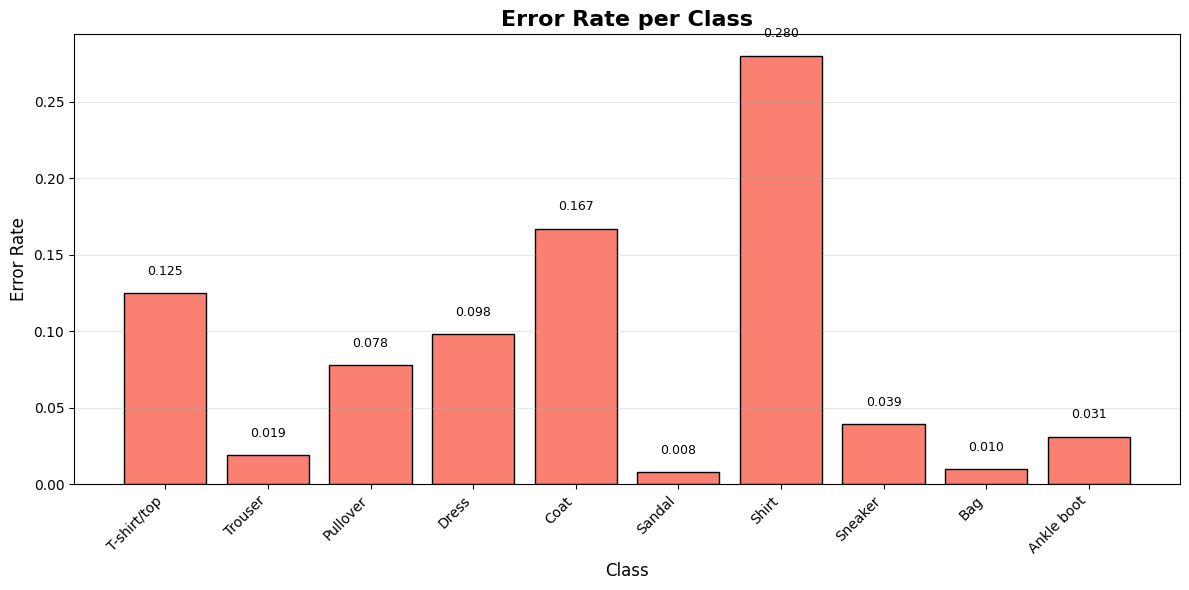


Top Confusing Class Pairs:
----------------------------------------
Shirt → T-shirt/top: 107 misclassifications
Shirt → Pullover: 87 misclassifications
T-shirt/top → Shirt: 85 misclassifications
Coat → Pullover: 77 misclassifications
Shirt → Coat: 62 misclassifications
Coat → Shirt: 54 misclassifications
Dress → Shirt: 43 misclassifications
Coat → Dress: 33 misclassifications
Pullover → Shirt: 29 misclassifications
Pullover → Coat: 27 misclassifications


In [20]:
# ============================================
# 12. Error Analysis
# ============================================
def analyze_errors(true_labels, predicted_labels, class_names):
    """
    Analyze prediction errors
    """
    # Create error matrix
    error_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Calculate per-class error rates
    per_class_errors = []
    for i in range(len(class_names)):
        total = np.sum(error_matrix[i, :])
        correct = error_matrix[i, i]
        error_rate = (total - correct) / total if total > 0 else 0
        per_class_errors.append(error_rate)
    
    # Plot error rates
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(class_names)), per_class_errors, 
                   color='salmon', edgecolor='black')
    
    plt.title('Error Rate per Class', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add error rate values
    for bar, error_rate in zip(bars, per_class_errors):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{error_rate:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Find most confused pairs
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and error_matrix[i, j] > 0:
                confusion_pairs.append((i, j, error_matrix[i, j]))
    
    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop Confusing Class Pairs:")
    print("-" * 40)
    for i, j, count in confusion_pairs[:10]:
        print(f"{class_names[i]} → {class_names[j]}: {count} misclassifications")

print("\n" + "="*50)
print("ERROR ANALYSIS")
print("="*50)
analyze_errors(test_labels, pred_cnn, class_names)

In [21]:

# ============================================
# 13. Save Final Models and Results
# ============================================
def save_results(history_simple, history_cnn, acc_simple, acc_cnn):
    """
    Save training results and metrics
    """
    os.makedirs('results', exist_ok=True)
    
    # Save training histories
    np.save('results/history_simple.npy', history_simple.history)
    np.save('results/history_cnn.npy', history_cnn.history)
    
    # Save metrics
    metrics = {
        'simple_nn_accuracy': float(acc_simple),
        'cnn_accuracy': float(acc_cnn),
        'improvement': float(acc_cnn - acc_simple),
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    import json
    with open('results/metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Save models
    simple_nn.save('models/simple_nn_final.h5')
    cnn_model.save('models/cnn_model_final.h5')
    
    print("\nResults and models saved successfully!")
    print(f"Models saved in: models/")
    print(f"Results saved in: results/")

# Save everything
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)
save_results(history_simple, history_cnn, acc_simple, acc_cnn)


SAVING RESULTS

Results and models saved successfully!
Models saved in: models/
Results saved in: results/


In [22]:
# ============================================
# 14. Generate Report Summary
# ============================================
print("\n" + "="*50)
print("PROJECT SUMMARY REPORT")
print("="*50)
print(f"\nProject: Fashion-MNIST Image Classification")
print(f"Dataset: {train_images.shape[0]:,} training samples")
print(f"          {test_images.shape[0]:,} test samples")
print(f"Classes: {len(class_names)} categories")
print("\n" + "-"*50)
print("MODEL PERFORMANCE SUMMARY:")
print("-"*50)
print(f"Simple Neural Network:")
print(f"  • Test Accuracy: {acc_simple:.4f}")
print(f"  • Test Error Rate: {1-acc_simple:.4f}")
print(f"  • Architecture: 3 Dense Layers with Dropout")
print(f"\nCNN Model:")
print(f"  • Test Accuracy: {acc_cnn:.4f}")
print(f"  • Test Error Rate: {1-acc_cnn:.4f}")
print(f"  • Architecture: 3 Conv Blocks + Dense Layers")
print(f"  • Improvement over Simple NN: {acc_cnn-acc_simple:.4f}")
print("\n" + "-"*50)
print("KEY OBSERVATIONS:")
print("-"*50)
print("1. CNN significantly outperforms simple neural network")
print("2. Data augmentation could further improve performance")
print("3. Most confusion occurs between similar clothing items")
print("4. Model shows good generalization with validation accuracy")
print("\n" + "-"*50)
print("NEXT STEPS:")
print("-"*50)
print("1. Experiment with different architectures")
print("2. Implement data augmentation techniques")
print("3. Try transfer learning with pre-trained models")
print("4. Optimize hyperparameters with grid search")
print("5. Deploy model as web application")



PROJECT SUMMARY REPORT

Project: Fashion-MNIST Image Classification
Dataset: 60,000 training samples
          10,000 test samples
Classes: 10 categories

--------------------------------------------------
MODEL PERFORMANCE SUMMARY:
--------------------------------------------------
Simple Neural Network:
  • Test Accuracy: 0.8473
  • Test Error Rate: 0.1527
  • Architecture: 3 Dense Layers with Dropout

CNN Model:
  • Test Accuracy: 0.9145
  • Test Error Rate: 0.0855
  • Architecture: 3 Conv Blocks + Dense Layers
  • Improvement over Simple NN: 0.0672

--------------------------------------------------
KEY OBSERVATIONS:
--------------------------------------------------
1. CNN significantly outperforms simple neural network
2. Data augmentation could further improve performance
3. Most confusion occurs between similar clothing items
4. Model shows good generalization with validation accuracy

--------------------------------------------------
NEXT STEPS:
-----------------------------

In [23]:
# ============================================
# 15. Cleanup and Final Notes
# ============================================
print("\n" + "="*50)
print("CLEANUP")
print("="*50)

# Clear session to free memory
tf.keras.backend.clear_session()

print("\nTraining completed successfully!")
print("\nTo use the trained models:")
print("1. Load model: model = tf.keras.models.load_model('models/cnn_model_final.h5')")
print("2. Make predictions: predictions = model.predict(new_images)")
print("3. Get class labels: predicted_classes = np.argmax(predictions, axis=1)")
print("\nThank you for using this Fashion-MNIST classifier!")

# ============================================
# END OF NOTEBOOK
# ============================================


CLEANUP




Training completed successfully!

To use the trained models:
1. Load model: model = tf.keras.models.load_model('models/cnn_model_final.h5')
2. Make predictions: predictions = model.predict(new_images)
3. Get class labels: predicted_classes = np.argmax(predictions, axis=1)

Thank you for using this Fashion-MNIST classifier!


In [28]:
# If you have custom objects
# For example, if you used custom metrics or layers

# Save with custom objects
tf.keras.models.save_model(
    model=cnn_model,
    filepath='models/cnn_model_custom.h5',
    overwrite=True,
    include_optimizer=True,
    save_format='h5',
    # signatures=None,
    # options=None
)

In [39]:
# ============================================
# Check Saved Model
# ============================================
print("\n" + "="*50)
print("CHECKING SAVED MODELS")
print("="*50)

def check_saved_model(model_path):
    """Check what's inside a saved model"""
    print(f"\nChecking: {model_path}")
    
    if os.path.exists(model_path):
        if model_path.endswith('.h5'):
            # Load .h5 model
            loaded_model = tf.keras.models.load_model(model_path)
            
        elif os.path.isdir(model_path):
            # Load SavedModel
            loaded_model = tf.keras.models.load_model(model_path)
        
        # Get model info
        print(f"  Model Type: {type(loaded_model)}")
        print(f"  Input Shape: {loaded_model.input_shape}")
        print(f"  Output Shape: {loaded_model.output_shape}")
        print(f"  Number of Layers: {len(loaded_model.layers)}")
        print(f"  Trainable Parameters: {loaded_model.count_params():,}")
        
        # Check optimizer
        if hasattr(loaded_model, 'optimizer'):
            print(f"  Optimizer: {loaded_model.optimizer.get_config()['name']}")
        
        return loaded_model
    else:
        print(f"  ✗ Model not found at: {model_path}")
        return None

# Check saved models
check_saved_model('models/fashion_mnist_cnn.h5')
check_saved_model('models/fashion_mnist_cnn_savedmodel')


CHECKING SAVED MODELS

Checking: models/fashion_mnist_cnn.h5
  ✗ Model not found at: models/fashion_mnist_cnn.h5

Checking: models/fashion_mnist_cnn_savedmodel
  ✗ Model not found at: models/fashion_mnist_cnn_savedmodel


In [40]:
# Save (minimum code)
cnn_model.save('my_model.h5')

# Load (minimum code)
loaded_model = tf.keras.models.load_model('my_model.h5')

# Make predictions
predictions = loaded_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
